In [1]:
# imports
import cv2
import os
import numpy as np
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import PIL
import io
import html
import time
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torchvision.transforms.functional  import InterpolationMode
import torchvision
import torch
import torch
import torch.nn as nn
from torchsummary import summary
from statistics import mean
import PIL
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import datetime
from google.colab import files




**Project Scope**:
Build a CNN classifier from scratch, on your own data that works on your live stream.

1. Acquire dataset (Train and Validation):

   Grab frames from your camera for 3 classes (your own selection).
   The amount of data to collect, is decided by you to reach good live performance.
2. Define pytorch dataset and data loader:
Define train and validation datasets and dataloader using **dset.ImageFolder(...)** with proper transforms. Also plot a few training and validation batches. 

3. Define your CNN network (**must use pytorch, and build your own network**)
4. Train your network:

   Train the network, print training accuracy and loss per epoch, and also for the validation. **Save the best model to disk, and download it**.
   Plot a few validation batches, with their labels and their predictions.

5. Live model inference:
Connect to your laptop camera, grab frame by frame, and plot on the image the classification of the frame. If you did everything right, your model should work quite well.

**items to submit for this assignment**:
1. Students that will demonstrate their project on live stream (and it really works..) until the deadline, will not have to submit any item
2. Otherwise submit the following:
   - This notebook, filled with all the **#place your code here** areas
   - your model saved for inference
   - 3 batches on the validation, with labels and predictions
   - 3 Minutes video file, demonstrating the student performing the 3 classes, with the model classification per frame plotted in the video


#Data set collection#

In [2]:
# Create Directories
dataset_dir = './dataset/'
num_classes = 3

#describe your classes
text_for_classes = ['Glasses','Hat','Nothing']


num_of_images_to_save = 100

os.mkdir(dataset_dir)
os.mkdir(dataset_dir + 'train')
os.mkdir(dataset_dir + 'test')

#Create directories
[os.mkdir(dataset_dir + 'train/' + str(i)) for i in range(num_classes)]
[os.mkdir(dataset_dir + 'test/' + str(i)) for i in range(num_classes)]


In [3]:
#define your own video width and height
width = 240
height = 200

# functions for capturing webcam  
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes


def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame(width, height) {
      if (!shutdown) {
         window.requestAnimationFrame(function() {
            onAnimationFrame(width, height);
    }); 
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, width, height);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom(width, height) {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "Status:";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '' +
          'When finished, click here or on the video to stop this demo';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = width; //video.videoWidth;
      captureCanvas.height = height; //video.videoHeight;
      window.requestAnimationFrame(function() {
      onAnimationFrame(width, height);
    });
      return stream;
    }

 async function stop_sream() {
        shutdown = true;
        removeDom();
        
        return '';
 }

    async function stream_frame(label, imgData, width, height) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom(width, height);
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox, width, videoHeight):
  data = eval_js('stream_frame("{}", "{}", "{}", "{}")'.format(label, bbox, width, height))
  return data

def video_stream_stop():
  eval_js('stop_sream("{}")')


In [4]:
from datetime import datetime
def grab_dataset(save_path):
    for i in range(num_classes):
      input('Press Enter to capture class ' + text_for_classes[i] + '...')
      # start streaming video from webcam
      frame_num = 0
      saved_frames = 0
      video_stream()
      # label for video
      label_html = 'Capturing...'
      # initialze bounding box to empty
      bbox = ''
      count = 0 
      file_names = []
      frames = []  
      while True:
          frame_num = frame_num + 1
          js_reply = video_frame(label_html, bbox, width, height)
          if not js_reply:
              break

          # convert JS response to OpenCV Image
          frame = js_to_image(js_reply["img"])

          # Save Frames
          label_html = 'Saving...' + str(saved_frames)
          file_name = save_path + str(i) + '/' + datetime.now().strftime("%m_%d_%Y_%H_%M_%S_") + str(frame_num) + '.jpg'
          file_names.append(file_name)
          frames.append(frame)
            #cv2.imwrite(file_name, frame)
          saved_frames = saved_frames + 1

          if saved_frames == num_of_images_to_save:
            video_stream_stop()
            print ('saving to disk...')
            for i,f in enumerate(file_names):
              cv2.imwrite(f, frames[i])
            break
 


In [5]:
# grab your dataset --> this should be an ongoing process, till you get good performance

grab_dataset(dataset_dir + '/train/')
grab_dataset(dataset_dir + '/test/')

Press Enter to capture class Glasses...


<IPython.core.display.Javascript object>

saving to disk...
Press Enter to capture class Hat...


<IPython.core.display.Javascript object>

saving to disk...
Press Enter to capture class Nothing...


<IPython.core.display.Javascript object>

saving to disk...
Press Enter to capture class Glasses...


<IPython.core.display.Javascript object>

saving to disk...
Press Enter to capture class Hat...


<IPython.core.display.Javascript object>

saving to disk...
Press Enter to capture class Nothing...


<IPython.core.display.Javascript object>

saving to disk...


In [6]:
# download dataset (so can merge with the dataset you already collected, and later upload it to colab)
from google.colab import files
!zip -r ./ds.zip ./dataset/
files.download('./ds.zip')

  adding: dataset/ (stored 0%)
  adding: dataset/test/ (stored 0%)
  adding: dataset/test/2/ (stored 0%)
  adding: dataset/test/2/04_16_2023_16_24_01_65.jpg (deflated 4%)
  adding: dataset/test/2/04_16_2023_16_24_12_79.jpg (deflated 4%)
  adding: dataset/test/2/04_16_2023_16_23_19_7.jpg (deflated 4%)
  adding: dataset/test/2/04_16_2023_16_24_11_77.jpg (deflated 4%)
  adding: dataset/test/2/04_16_2023_16_24_28_97.jpg (deflated 4%)
  adding: dataset/test/2/04_16_2023_16_24_19_86.jpg (deflated 4%)
  adding: dataset/test/2/04_16_2023_16_24_26_94.jpg (deflated 4%)
  adding: dataset/test/2/04_16_2023_16_24_05_71.jpg (deflated 4%)
  adding: dataset/test/2/04_16_2023_16_23_54_56.jpg (deflated 4%)
  adding: dataset/test/2/04_16_2023_16_23_52_53.jpg (deflated 4%)
  adding: dataset/test/2/04_16_2023_16_23_23_12.jpg (deflated 4%)
  adding: dataset/test/2/04_16_2023_16_24_13_80.jpg (deflated 4%)
  adding: dataset/test/2/04_16_2023_16_24_21_88.jpg (deflated 4%)
  adding: dataset/test/2/04_16_2023_16

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
# download dataset
from google.colab import files

files.upload()

Saving dataset.zip to dataset.zip


In [6]:
#extract your dataset zip file
!unzip /content/dataset.zip

Archive:  /content/dataset.zip
   creating: dataset/
   creating: dataset/test/
   creating: dataset/test/0/
  inflating: dataset/test/0/04_10_2023_15_22_50_1.jpg  
  inflating: dataset/test/0/04_10_2023_15_22_50_2.jpg  
  inflating: dataset/test/0/04_10_2023_15_22_51_3.jpg  
  inflating: dataset/test/0/04_10_2023_15_22_52_4.jpg  
  inflating: dataset/test/0/04_10_2023_15_22_53_5.jpg  
  inflating: dataset/test/0/04_10_2023_15_22_53_6.jpg  
  inflating: dataset/test/0/04_10_2023_15_22_53_7.jpg  
  inflating: dataset/test/0/04_10_2023_15_22_55_8.jpg  
  inflating: dataset/test/0/04_10_2023_15_22_55_9.jpg  
  inflating: dataset/test/0/04_10_2023_15_22_56_10.jpg  
  inflating: dataset/test/0/04_10_2023_15_22_57_11.jpg  
  inflating: dataset/test/0/04_10_2023_15_22_57_12.jpg  
  inflating: dataset/test/0/04_10_2023_15_22_58_13.jpg  
  inflating: dataset/test/0/04_10_2023_15_22_59_14.jpg  
  inflating: dataset/test/0/04_10_2023_15_23_00_15.jpg  
  inflating: dataset/test/0/04_10_2023_15_23_

#Dataset definition#

In [7]:
# define:
# Batch size
BATCH_SIZE = 32
# Train and validation transforms using transforms.Compose
transform = transforms.Compose([transforms.ToTensor()])#turns photo to tensor
# Train and validation datasets using dset.ImageFolder
trainset = dset.ImageFolder("./dataset/train",transform)
testset = dset.ImageFolder("./dataset/test",transform)

# Train and validation dataloaders using torch.utils.data.DataLoader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
dataloader_train = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
dataloader_test = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)




# print the length of your train and validation sets
print(len(dataloader_train.dataset))
print(len(dataloader_test.dataset))


1457
1411


Image batch dimensions: torch.Size([32, 3, 200, 240])
Image label dimensions: torch.Size([32])


RuntimeError: ignored

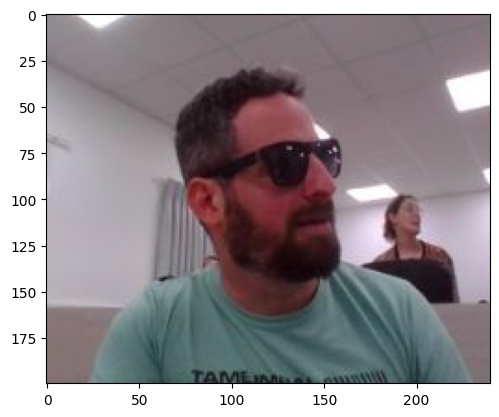

In [8]:
from google.colab.patches import cv2_imshow
## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
   npimg = img.numpy()
   plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(dataloader_train)
images, labels = next(dataiter)
print("Image batch dimensions:", images.shape)
print("Image label dimensions:", labels.shape)
plt.imshow(  images[0].permute(1, 2, 0)  )

## show images
imshow(torchvision.utils.make_grid(images))

#Training#

In [9]:
class liveClassifier(nn.Module):
  def __init__(self):
    super(liveClassifier, self).__init__()
    #conv - max-con-max
    #3x240x200
    self.conv1 = nn.Conv2d(3, 32, 3, stride=1, padding=0)
    self.pool1 = nn.MaxPool2d(2)
    #3x120x100
    self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=0)
    self.pool2 = nn.MaxPool2d(2)
    #64X60x50
    self.conv3 = nn.Conv2d(64, 128, 3, stride=1, padding=0)
    self.pool3 = nn.MaxPool2d(2)
    #128x30x25
    self.conv4 = nn.Conv2d(128, 128, 3, stride=1, padding=0)
    self.pool4 = nn.MaxPool2d(2)
    #128, 28, 23
    self.conv5 = nn.Conv2d(128, 64, 3, stride=1, padding=0)
    self.pool5 = nn.MaxPool2d(2)
    #fully connected layers
    self.fc1 = nn.Linear(64*5*4, 64, bias=True)
    self.fc2 = nn.Linear(64, 3)


    #forward function
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    x = F.relu(self.conv3(x))
    x = self.pool3(x)
    x = F.relu(self.conv4(x))
    x = self.pool4(x)
    x = F.relu(self.conv5(x))
    x = self.pool5(x)
    x = x.reshape(-1, 64*5*4)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    out = F.softmax(x, dim=1)
    return out


In [10]:

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

model = liveClassifier().to(device)

summary(model, (3, 240, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 238, 198]             896
         MaxPool2d-2          [-1, 32, 119, 99]               0
            Conv2d-3          [-1, 64, 117, 97]          18,496
         MaxPool2d-4           [-1, 64, 58, 48]               0
            Conv2d-5          [-1, 128, 56, 46]          73,856
         MaxPool2d-6          [-1, 128, 28, 23]               0
            Conv2d-7          [-1, 128, 26, 21]         147,584
         MaxPool2d-8          [-1, 128, 13, 10]               0
            Conv2d-9            [-1, 64, 11, 8]          73,792
        MaxPool2d-10             [-1, 64, 5, 4]               0
           Linear-11                   [-1, 64]          81,984
           Linear-12                    [-1, 3]             195
Total params: 396,803
Trainable params: 396,803
Non-trainable params: 0
-------------------------------

In [11]:
#Define your loss criterion, and optimizer
learning_rate = 0.001
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum = 0.9) # with this optim the score didnt rise from 33 0.0002


In [12]:
#function for training
def train(model, loss_fn, optimizer):
    #set model in train mode
    model.train()
    
    train_batch_losses = []
    
    for batch, labels in dataloader_train:
        batch = batch.to(device)
        labels = labels.to(device)
        #zero out the optimizer
        optimizer.zero_grad()
        y_pred = model(batch)
        loss = loss_fn(y_pred, labels)
        #backpropogation
        loss.backward()
        #updating weights
        optimizer.step()
        
        train_batch_losses.append(float(loss))
        
        mean_loss = mean(train_batch_losses)
        
    return mean_loss

#function for testing
def validate(model, loss_fn, optimizer):
    model.eval()
    
    predictions = []
    
    with torch.no_grad():
        validation_batch_losses = []
        
        for batch, labels in dataloader_test:
            batch = batch.to(device)
            labels = labels.to(device)

            labels_pred = model(batch)
            loss = loss_fn(labels_pred, labels)
            validation_batch_losses.append(float(loss))
            mean_loss = mean(validation_batch_losses)
            
    return mean_loss

#model for accuracy score
def accuracy(model, loader):
    correct = 0
    total = 0
    
    model.eval()
    
    with torch.no_grad():
        for batch, labels in loader:
            batch = batch.to(device)
            labels = labels.to(device)
        
            labels_pred = model(batch)
        
            _, predicted = torch.max(labels_pred.data, 1)
        
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
    return (100 * correct / total)

In [15]:

#train loop

num_epochs = 30
train_losses = []
valid_losses = []

train_accuracies = []
valid_accuracies = []
best_train_accuracy = 0
best_test_accuracy = 0

for epoch in range(num_epochs):

  print('Epoch: ', epoch)
  
  train_loss = train(model, criterion, optimizer)
  train_accuracy = accuracy(model, dataloader_train)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  
  print('Training loss:', train_loss)
  print('Training accuracy: {}%'.format(train_accuracy))
  
  valid_loss = validate(model, criterion, optimizer)
  valid_accuracy = accuracy(model, dataloader_test)
  valid_losses.append(valid_loss)
  valid_accuracies.append(valid_accuracy)
  
  print('Validation loss:', valid_loss)
  print('Validation accuracy: {}%'.format(valid_accuracy))
  

  if valid_accuracy > best_test_accuracy:
    torch.save(model.state_dict(), dataset_dir + 'savedmodel')
    best_train_accuracy = train_accuracy
    best_test_accuracy = valid_accuracy
    bestModel = model.state_dict()






Epoch:  0
Training loss: 0.5652223890242369
Training accuracy: 98.42141386410432%
Validation loss: 0.6473090595669216
Validation accuracy: 90.14883061658398%
Epoch:  1
Training loss: 0.569353901821634
Training accuracy: 98.76458476321208%
Validation loss: 0.6430217875374689
Validation accuracy: 90.99929128277817%
Epoch:  2
Training loss: 0.5671921385371167
Training accuracy: 98.62731640356898%
Validation loss: 0.6594296296437582
Validation accuracy: 89.65272856130404%
Epoch:  3
Training loss: 0.5692577426848204
Training accuracy: 98.76458476321208%
Validation loss: 0.6563632395532396
Validation accuracy: 89.79447200566973%
Epoch:  4
Training loss: 0.5713441799516263
Training accuracy: 97.94097460535346%
Validation loss: 0.6357323143217298
Validation accuracy: 91.35364989369242%
Epoch:  5
Training loss: 0.5647217514722244
Training accuracy: 98.62731640356898%
Validation loss: 0.6318282829390631
Validation accuracy: 91.42452161587526%
Epoch:  6
Training loss: 0.5665563267210255
Training 

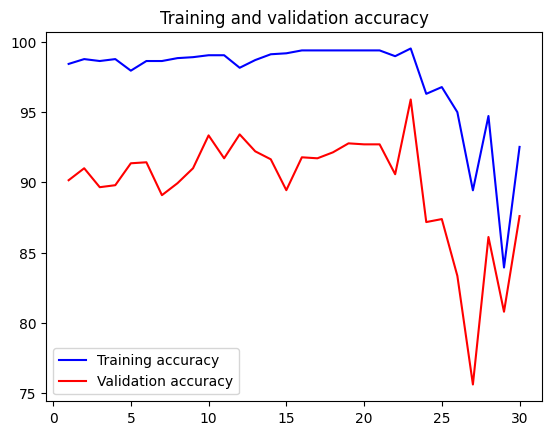

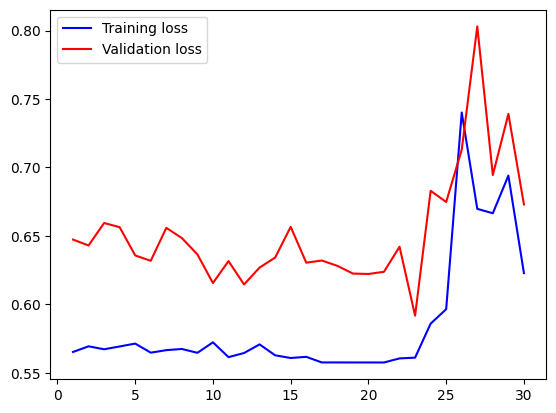

In [16]:
epochs = range(1, 30 + 1)

plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(epochs, valid_accuracies, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, valid_losses, 'r', label='Validation loss')
plt.legend()

plt.show()

In [17]:
print(f"best trainig accuracy: {best_train_accuracy}, best test accuracy: {best_test_accuracy}")

best trainig accuracy: 99.51956074124914, best test accuracy: 95.88944011339476


In [18]:
# download model
files.download('/content/dataset/savedmodel')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
# upload model
files.upload()

Saving savedmodel to savedmodel


{'savedmodel': b'PK\x03\x04\x00\x00\x08\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x13\x00\x0f\x00savedmodel/data.pklFB\x0b\x00ZZZZZZZZZZZ\x80\x02ccollections\nOrderedDict\nq\x00)Rq\x01(X\x0c\x00\x00\x00conv1.weightq\x02ctorch._utils\n_rebuild_tensor_v2\nq\x03((X\x07\x00\x00\x00storageq\x04ctorch\nFloatStorage\nq\x05X\x01\x00\x00\x000q\x06X\x06\x00\x00\x00cuda:0q\x07M`\x03tq\x08QK\x00(K K\x03K\x03K\x03tq\t(K\x1bK\tK\x03K\x01tq\n\x89h\x00)Rq\x0btq\x0cRq\rX\n\x00\x00\x00conv1.biasq\x0eh\x03((h\x04h\x05X\x01\x00\x00\x001q\x0fX\x06\x00\x00\x00cuda:0q\x10K tq\x11QK\x00K \x85q\x12K\x01\x85q\x13\x89h\x00)Rq\x14tq\x15Rq\x16X\x0c\x00\x00\x00conv2.weightq\x17h\x03((h\x04h\x05X\x01\x00\x00\x002q\x18X\x06\x00\x00\x00cuda:0q\x19M\x00Htq\x1aQK\x00(K@K K\x03K\x03tq\x1b(M \x01K\tK\x03K\x01tq\x1c\x89h\x00)Rq\x1dtq\x1eRq\x1fX\n\x00\x00\x00conv2.biasq h\x03((h\x04h\x05X\x01\x00\x00\x003q!X\x06\x00\x00\x00cuda:0q"K@tq#QK\x00K@\x85q$K\x01\x85q%\x89h\x00)Rq&tq\'Rq(X\x0c\x00\

In [20]:
# load model

model = liveClassifier()
model.load_state_dict(torch.load('/content/savedmodel'))
model.to(device)
model.eval()

liveClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1280, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
)

## Inference

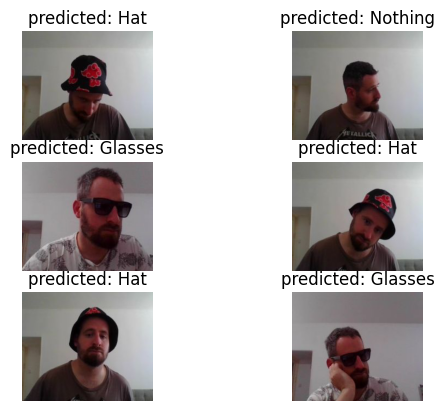

In [26]:
#Plot few batches with their labels and predictions
dataiter = iter(dataloader_train)
images, labels = next(dataiter)
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataiter):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {text_for_classes[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
visualize_model(model)

In [21]:
from google.colab.patches import cv2_imshow

def pred_from_tensor(tensor):
    pred_index = np.argmax(tensor.detach().numpy())
    #print(pred_index)
    return text_for_classes[pred_index]


frame_num = 0
saved_frames = 0
video_stream() 
label_html = ''
bbox = ''
frames = []  
while True:
  frame_num = frame_num + 1
  js_reply = video_frame(label_html, bbox, width, height)
  if not js_reply:
    break

          # convert JS response to OpenCV Image
  frame_bgr = js_to_image(js_reply["img"])
  #cv2_imshow(frame_bgr)
  
  #frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
  #cv2_imshow(frame_bgr)
  transform = transforms.Compose([transforms.ToTensor()])
  input = transform(frame_bgr).to(device)
  input = torch.unsqueeze(input, 0)
  #print(input)
  pred = model(input)
  pred = pred_from_tensor(pred.cpu())
  #print(pred)
  label_html = pred



<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored